<a href="https://colab.research.google.com/github/ENEE439d-TEXTML/TextML/blob/master/Sentiment_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## tutorial site: 

https://towardsdatascience.com/sentiment-analysis-using-lstm-and-glove-embeddings-99223a87fe8e

https://towardsdatascience.com/word-embeddings-for-sentiment-analysis-65f42ea5d26e

In [3]:
#import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data  = pd.read_csv("/content/drive/MyDrive/UMD - senior year/spring 2022/439D/project/data.csv")

# Feature Engineeing: Fix Up Data

## Setup necessary libraries
> the imports and stuff

In [5]:
#import all necessary libraries for this tutorial

import re
import collections

from pathlib import Path
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import models
from keras import layers
import keras

In [6]:
data.head()

,no,paper,cited_paper,label,text
0,0,A00-1043,A00-2024,0,We analyzed a set of articles and identified s...
1,1,H05-1033,A00-2024,0,Table 3: Example compressions Compression AvgL...
2,2,I05-2009,A00-2024,0,5.3 Related works and discussion Our two-step ...
3,3,I05-2009,A00-2024,0,(1999) proposed a summarization system based o...
4,4,I05-2009,A00-2024,0,We found that the deletion of lead parts did n...


## Removing non-alphabetic characters
> remove words and characters that aren't useful from sentences in dataset

In [7]:
#define functions to things with no sentiment value (irrelevant words)
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

characters = [""]

#function to remove stopwords
def remove_stopwords(data):
  data['review_without_stopwords'] = data['text'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
  return data

#function to remove non-alphabetical tags
def remove_tags(string):
    #result = re.sub('[\d<.*?:>()-,;|/@!#$%^&*~`_=+]','',string)

    pattern = re.compile('[\W_0-9]+')
    dirty_list = string.split()
    clean_list = [pattern.sub('', word) for word in dirty_list]
    result = ' '.join(clean_list)
    
    # result = re.sub('[\W_0-9]+','',string)    #see https://blog.finxter.com/how-to-remove-all-non-alphabet-characters-from-a-string/ for explanation
    # result = re.sub('  ',' ',result)
    return result

In [8]:
#remove stopwords
clean_dataset = remove_stopwords(data)
clean_dataset['w/o stopwords or tags']= clean_dataset['review_without_stopwords'].apply(lambda cw : remove_tags(cw))
clean_dataset

,no,paper,cited_paper,label,text,review_without_stopwords,w/o stopwords or tags
0,0,A00-1043,A00-2024,0,We analyzed a set of articles and identified s...,We analyzed set articles identified six major ...,We analyzed set articles identified six major ...
1,1,H05-1033,A00-2024,0,Table 3: Example compressions Compression AvgL...,Table 3: Example compressions Compression AvgL...,Table Example compressions Compression AvgLen...
2,2,I05-2009,A00-2024,0,5.3 Related works and discussion Our two-step ...,5.3 Related works discussion Our two-step mode...,Related works discussion Our twostep model es...
3,3,I05-2009,A00-2024,0,(1999) proposed a summarization system based o...,(1999) proposed summarization system based dra...,proposed summarization system based draft rev...
4,4,I05-2009,A00-2024,0,We found that the deletion of lead parts did n...,We found deletion lead parts not occur often s...,We found deletion lead parts not occur often s...
...,...,...,...,...,...,...,...
994,994,N09-1053,J92-4003,0,While we can only compare class models with wo...,While can compare class models word models lar...,While can compare class models word models lar...
995,995,P01-1046,J92-4003,0,(1999) and Lee (1999)) can be generally divide...,(1999) Lee (1999)) can generally divided three...,Lee can generally divided three types discou...
996,996,P01-1046,J92-4003,0,Classes can be induced directly from the corpu...,Classes can induced directly corpus (Pereira e...,Classes can induced directly corpus Pereira et...
997,997,P01-1068,J92-4003,0,And we consider that word pairs that have a sm...,And consider word pairs small distance vectors...,And consider word pairs small distance vectors...


In [9]:
clean_dataset

,no,paper,cited_paper,label,text,review_without_stopwords,w/o stopwords or tags
0,0,A00-1043,A00-2024,0,We analyzed a set of articles and identified s...,We analyzed set articles identified six major ...,We analyzed set articles identified six major ...
1,1,H05-1033,A00-2024,0,Table 3: Example compressions Compression AvgL...,Table 3: Example compressions Compression AvgL...,Table Example compressions Compression AvgLen...
2,2,I05-2009,A00-2024,0,5.3 Related works and discussion Our two-step ...,5.3 Related works discussion Our two-step mode...,Related works discussion Our twostep model es...
3,3,I05-2009,A00-2024,0,(1999) proposed a summarization system based o...,(1999) proposed summarization system based dra...,proposed summarization system based draft rev...
4,4,I05-2009,A00-2024,0,We found that the deletion of lead parts did n...,We found deletion lead parts not occur often s...,We found deletion lead parts not occur often s...
...,...,...,...,...,...,...,...
994,994,N09-1053,J92-4003,0,While we can only compare class models with wo...,While can compare class models word models lar...,While can compare class models word models lar...
995,995,P01-1046,J92-4003,0,(1999) and Lee (1999)) can be generally divide...,(1999) Lee (1999)) can generally divided three...,Lee can generally divided three types discou...
996,996,P01-1046,J92-4003,0,Classes can be induced directly from the corpu...,Classes can induced directly corpus (Pereira e...,Classes can induced directly corpus Pereira et...
997,997,P01-1068,J92-4003,0,And we consider that word pairs that have a sm...,And consider word pairs small distance vectors...,And consider word pairs small distance vectors...


## Remove data that is too large

In [10]:
# get maxLen for the maximum length of a text 
maxLen = max(clean_dataset['w/o stopwords or tags'].apply(len))

#the row of the maxLen text
clean_dataset.loc[clean_dataset['w/o stopwords or tags'].apply(len) == max(clean_dataset['w/o stopwords or tags'].apply(len))]

,no,paper,cited_paper,label,text,review_without_stopwords,w/o stopwords or tags
225,225,W99-0505,C94-2113,0,Towards a Meaning-Full Comparison of Lexieal R...,Towards Meaning-Full Comparison Lexieal Resour...,Towards MeaningFull Comparison Lexieal Resourc...


In [11]:
# sizes of texts 
clean_dataset['w/o stopwords or tags'].apply(len).sort_values()

144        9
127       11
393       12
704       13
642       13
       ...  
637      781
321      835
908     1717
909     3000
225    22682
Name: w/o stopwords or tags, Length: 999, dtype: int64

In [12]:
#try removing thousand word lines from dataset to make training easier
smaller_clean_dataset = clean_dataset.loc[clean_dataset['w/o stopwords or tags'].apply(len) < 1000]
smaller_clean_dataset['w/o stopwords or tags'].apply(len).sort_values()

144      9
127     11
393     12
704     13
642     13
      ... 
896    596
907    730
561    749
637    781
321    835
Name: w/o stopwords or tags, Length: 996, dtype: int64

In [13]:
#redefine maxlen as length of new longest sentence
maxLen = max(smaller_clean_dataset['w/o stopwords or tags'].apply(len))

## One hot encode labels

In [14]:
#copy original dataset as backup if mess up
smaller_clean_dataset_orig = smaller_clean_dataset.copy()

#add categorical labels for label to original dataset 
smaller_clean_dataset = pd.concat([smaller_clean_dataset, pd.get_dummies(smaller_clean_dataset['label'], prefix='label_')], axis=1)
smaller_clean_dataset.head()

,no,paper,cited_paper,label,text,review_without_stopwords,w/o stopwords or tags,label__-1,label__0,label__1
0,0,A00-1043,A00-2024,0,We analyzed a set of articles and identified s...,We analyzed set articles identified six major ...,We analyzed set articles identified six major ...,0,1,0
1,1,H05-1033,A00-2024,0,Table 3: Example compressions Compression AvgL...,Table 3: Example compressions Compression AvgL...,Table Example compressions Compression AvgLen...,0,1,0
2,2,I05-2009,A00-2024,0,5.3 Related works and discussion Our two-step ...,5.3 Related works discussion Our two-step mode...,Related works discussion Our twostep model es...,0,1,0
3,3,I05-2009,A00-2024,0,(1999) proposed a summarization system based o...,(1999) proposed summarization system based dra...,proposed summarization system based draft rev...,0,1,0
4,4,I05-2009,A00-2024,0,We found that the deletion of lead parts did n...,We found deletion lead parts not occur often s...,We found deletion lead parts not occur often s...,0,1,0


In [15]:
smaller_clean_dataset.iloc[:, -3:].to_numpy().shape

(996, 3)

## Even out dataset by label
> Scale up the non-neutral sentiment data


In [16]:
#scale up the non-neutral sentiment data
smaller_clean_dataset['label'].value_counts()

# add all the 1 sentiment data in 11x + first 27 
# add all the 1 sentiment data in 42x + first 14

 0    896
 1     79
-1     21
Name: label, dtype: int64

In [17]:
# POSITIVE sentiment data -----
#repeat positive sentiment data 10 times
vertical_concat = smaller_clean_dataset.loc[smaller_clean_dataset['label'] == 1]
for i in range(9):
  vertical_concat = pd.concat([vertical_concat, smaller_clean_dataset.loc[smaller_clean_dataset['label'] == 1]], axis=0)

#add first 27 entries to that dataset
vertical_concat = pd.concat([vertical_concat, vertical_concat.iloc[:27]], axis=0)



# NEGATIVE sentiment data -----
#repeat positive sentiment data 40 times
vertical_concat2 = smaller_clean_dataset.loc[smaller_clean_dataset['label'] == -1]
for i in range(40):
  vertical_concat2 = pd.concat([vertical_concat2, smaller_clean_dataset.loc[smaller_clean_dataset['label'] == -1]], axis=0)

#add first 27 entries to that dataset
vertical_concat2 = pd.concat([vertical_concat2, vertical_concat2.iloc[:14]], axis=0)



print('new 1 label shape', vertical_concat.shape)
print('new -1 label shape', vertical_concat2.shape)
vertical_concat.head(3)
# vertical_concat2.head(3)

new 1 label shape (817, 10)
new -1 label shape (875, 10)


,no,paper,cited_paper,label,text,review_without_stopwords,w/o stopwords or tags,label__-1,label__0,label__1
6,6,I08-2101,A00-2024,1,"al., 1994), compression of sentences with Auto...","al., 1994), compression sentences Automatic Tr...",al compression sentences Automatic Translatio...,0,0,1
9,9,J02-4005,A00-2024,1,"But in fact, the issue of editing in text summ...","But fact, issue editing text summarization usu...",But fact issue editing text summarization usua...,0,0,1
21,21,W03-1102,A00-2024,1,The recent approach for editing extracted text...,The recent approach editing extracted text spa...,The recent approach editing extracted text spa...,0,0,1


In [18]:
#save old dataframe 
old_dataframe = smaller_clean_dataset.copy()

#concatenate the dataframes
non_neutral_data = pd.concat([vertical_concat, vertical_concat2], axis=0)
smaller_clean_dataset = pd.concat([smaller_clean_dataset, non_neutral_data], axis=0)

#shuffle data
from sklearn.utils import shuffle
smaller_clean_dataset = shuffle(smaller_clean_dataset, random_state=0)

smaller_clean_dataset['label'].value_counts()

-1    896
 0    896
 1    896
Name: label, dtype: int64

# Train and Test Model

## Testing with multiple outputs

In [19]:
# split into test and training data
X_train, X_test,Y_train, Y_test = train_test_split(smaller_clean_dataset['w/o stopwords or tags'], smaller_clean_dataset.iloc[:, -3:].to_numpy(), test_size=0.2, random_state = 45)

In [20]:
#Y_train 3D vector
#Y_train

#Y_train sentiment
(np.argmax(Y_train, axis=1)[:300] - 1)

array([-1,  1, -1,  1,  1, -1,  1,  0,  0,  0,  1,  0, -1,  1,  0,  0,  1,
        1,  0,  0,  1,  0, -1,  1,  0, -1,  0,  1,  0,  1,  1, -1,  0,  1,
        1, -1, -1,  0, -1,  0,  1,  1,  0, -1,  0,  1,  0,  1,  1,  1, -1,
       -1, -1,  0, -1,  0,  1,  1,  0,  1, -1,  1, -1,  0,  1,  0, -1,  1,
        0,  1,  1, -1, -1,  0,  1, -1, -1, -1, -1, -1,  0, -1,  0,  0, -1,
       -1, -1,  0,  1,  1,  1,  1, -1, -1, -1, -1,  0,  1,  0, -1,  1, -1,
        0, -1, -1,  0,  1, -1,  0, -1,  0,  0,  0,  1,  0, -1, -1,  1, -1,
       -1,  0, -1,  0,  0,  1, -1, -1, -1, -1,  0, -1,  1,  0,  1,  1, -1,
       -1,  1, -1,  1, -1, -1,  1, -1,  1,  1, -1,  1, -1, -1,  0, -1,  1,
       -1,  0,  1,  1,  1,  1,  0,  0, -1, -1,  1,  1,  0,  0,  0,  1,  0,
        0,  0,  0,  1,  1,  1, -1,  0,  1, -1, -1, -1,  1,  1,  0,  1, -1,
        1,  1,  1,  0,  0,  0,  0, -1,  1, -1,  1, -1,  1,  1,  1,  1,  0,
        0,  1,  1,  1,  1, -1, -1, -1,  0,  0,  1, -1, -1,  0,  1, -1,  0,
        1, -1,  1, -1,  0

In [21]:
# create list of unique words in sentences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

#creates dictionary of each {word: index}
words_to_index = tokenizer.word_index
words_to_index

{'al': 1,
 'et': 2,
 'church': 3,
 'used': 4,
 'information': 5,
 'method': 6,
 'not': 7,
 'models': 8,
 'hanks': 9,
 'model': 10,
 'tagging': 11,
 'can': 12,
 'word': 13,
 'performance': 14,
 'approach': 15,
 'the': 16,
 'cutting': 17,
 'translation': 18,
 'data': 19,
 'words': 20,
 'a': 21,
 'based': 22,
 'mutual': 23,
 'wsd': 24,
 'similarity': 25,
 'smith': 26,
 'language': 27,
 'approaches': 28,
 'this': 29,
 'semantic': 30,
 'lin': 31,
 'results': 32,
 'brown': 33,
 'proposed': 34,
 'similar': 35,
 'using': 36,
 'shown': 37,
 'statistical': 38,
 'dependency': 39,
 'methods': 40,
 'we': 41,
 'also': 42,
 'measure': 43,
 'collocations': 44,
 'wu': 45,
 'pos': 46,
 'markov': 47,
 'turney': 48,
 'for': 49,
 'work': 50,
 'in': 51,
 'machine': 52,
 'mi': 53,
 'including': 54,
 'one': 55,
 'unsupervised': 56,
 'two': 57,
 'reported': 58,
 'algorithm': 59,
 'johnson': 60,
 'large': 61,
 'brants': 62,
 'carpuat': 63,
 'wikipedia': 64,
 'kazama': 65,
 'torisawa': 66,
 'training': 67,
 'app

In [22]:
#function to read GloCe Vector file
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)



  return word_to_vec_map

In [23]:
# read in GloVe vector from Google Drive (premade mapping of words to be used for sentiment analysis)
word_to_vec_map = read_glove_vector('/content/drive/MyDrive/UMD - senior year/spring 2022/439D/project/glove.6B.50d.txt')

In [24]:
from tensorflow.keras.layers import Embedding


# create embedding matrix (all words in GloVe vector assigned to correct value matrix, all others assigend to 0 vector)
vocab_len = len(words_to_index) + 1
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))


#get glove coordinates of words that are in BOTH glove list and in training data sentences 
for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    print(word)
    emb_matrix[index, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)

al
et
church
used
information
method
not
models
hanks
model
tagging
can
word
performance
approach
the
cutting
translation
data
words
a
based
mutual
wsd
similarity
smith
language
approaches
this
semantic
lin
results
brown
proposed
similar
using
shown
statistical
dependency
methods
we
also
measure
collocations
wu
pos
markov
turney
for
work
in
machine
mi
including
one
unsupervised
two
reported
algorithm
johnson
large
wikipedia
kazama
training
applications
available
hidden
collins
eg
thus
well
since
use
lexical
mckeown
jing
systems
corpora
sentence
developed
patterns
gazetteer
distributional
no
syntactic
many
english
system
outperform
lins
text
features
modeling
pointwise
unlike
b
difficult
hmm
dagan
taggers
resources
version
better
processing
baseline
improve
although
networks
problem
score
found
corpus
number
chan
disambiguation
good
several
mihalcea
relations
uses
widely
applied
sense
however
wordnet
smt
identify
automatically
brill
techniques
our
learning
classes
koehn
zhang
recently
c

In [25]:
from keras.datasets import imdb
import pandas as pd
import numpy as np
from keras.layers import LSTM, Activation, Dropout, Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import Model
import string
import re
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split

In [26]:
# create model architecture
def imdb_rating(input_shape):

  X_indices = Input(input_shape)

  embeddings = embedding_layer(X_indices)

  X = LSTM(128, return_sequences=True)(embeddings)

  X = Dropout(0.6)(X)

  X = LSTM(128, return_sequences=True)(X)

  X = Dropout(0.6)(X)

  X = LSTM(128)(X)

  #X = Dense(1, activation='sigmoid')(X)

  X = Dense(3, activation='softmax')(X)

  model = Model(inputs=X_indices, outputs=X)

  return model

In [27]:
#tokenizer converts words in the sentence into its corresponding indexe 
print(X_train.iloc[-1])  
print(tokenizer.texts_to_sequences(X_train)[-1])
print('the word since, the first word of the last sentence in the dataset has index: ', words_to_index['regardless'])

We used pointwise mutual information PMI Church Hanks  obtain distances
[41, 4, 99, 23, 5, 467, 3, 9, 1228, 1645]
the word since, the first word of the last sentence in the dataset has index:  1976


In [28]:
#convert training data sentence words into its corresponding indexes
X_train_indices = tokenizer.texts_to_sequences(X_train)

#pad sentences of indexes so all same length
X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')
print('the shape of the new training data is 796 samples, each with 835 words (bc of padding): ', X_train_indices.shape)

the shape of the new training data is 796 samples, each with 835 words (bc of padding):  (2150, 835)


In [29]:
#train the model
model = imdb_rating((maxLen,))

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_indices, Y_train, batch_size=256, epochs=15)

Epoch 1/15
9/9 [==============================] - 19s 657ms/step - loss: 0.6683 - accuracy: 0.3405
Epoch 2/15
9/9 [==============================] - 6s 652ms/step - loss: 0.6401 - accuracy: 0.3326
Epoch 3/15
9/9 [==============================] - 6s 658ms/step - loss: 0.6381 - accuracy: 0.3191
Epoch 4/15
9/9 [==============================] - 6s 660ms/step - loss: 0.6368 - accuracy: 0.3363
Epoch 5/15
9/9 [==============================] - 6s 656ms/step - loss: 0.6367 - accuracy: 0.3433
Epoch 6/15
9/9 [==============================] - 6s 661ms/step - loss: 0.6366 - accuracy: 0.3465
Epoch 7/15
9/9 [==============================] - 6s 660ms/step - loss: 0.6368 - accuracy: 0.3256
Epoch 8/15
9/9 [==============================] - 6s 652ms/step - loss: 0.6366 - accuracy: 0.3423
Epoch 9/15
9/9 [==============================] - 6s 656ms/step - loss: 0.6365 - accuracy: 0.3442
Epoch 10/15
9/9 [==============================] - 6s 649ms/step - loss: 0.6369 - accuracy: 0.3316
Epoch 11/15
9/9 [=

In [30]:
#convert the testing data sentence words into its corresponding indexes
X_test_indices = tokenizer.texts_to_sequences(X_test)

#pad sentences of indexes so all same length
X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')
print('the shape of the new training data is 200 samples, each with 835 words (bc of padding): ', X_test_indices.shape)


model.evaluate(X_test_indices, Y_test)

the shape of the new training data is 200 samples, each with 835 words (bc of padding):  (538, 835)
17/17 [==============================] - 4s 129ms/step - loss: 0.6388 - accuracy: 0.2900


[0.638805091381073, 0.2899628281593323]

In [31]:
my_predictions = model.predict(X_test_indices)

In [32]:
my_predictions[:100]

array([[0.3615982 , 0.31838158, 0.32002026],
       [0.3615982 , 0.31838158, 0.3200203 ],
       [0.3615982 , 0.31838158, 0.32002026],
       [0.3615982 , 0.31838158, 0.3200203 ],
       [0.3615982 , 0.31838152, 0.32002026],
       [0.36159816, 0.31838158, 0.3200203 ],
       [0.3615982 , 0.31838158, 0.3200203 ],
       [0.36159816, 0.31838158, 0.3200203 ],
       [0.3615982 , 0.31838152, 0.32002026],
       [0.3615982 , 0.31838158, 0.32002026],
       [0.36159816, 0.31838158, 0.32002026],
       [0.3615982 , 0.31838158, 0.32002026],
       [0.36159816, 0.31838155, 0.3200203 ],
       [0.3615982 , 0.31838158, 0.32002026],
       [0.3615982 , 0.31838158, 0.3200203 ],
       [0.3615982 , 0.31838158, 0.3200203 ],
       [0.3615982 , 0.31838158, 0.3200203 ],
       [0.3615982 , 0.31838158, 0.3200203 ],
       [0.3615982 , 0.31838152, 0.32002026],
       [0.3615982 , 0.31838158, 0.32002026],
       [0.3615982 , 0.31838158, 0.32002026],
       [0.36159816, 0.31838158, 0.32002026],
       [0.

In [33]:
#take max of the softmax output
my_predictions_final = np.argmax(my_predictions, axis=1)

#map values back to (-1,0,1)
my_predictions_final - 1

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [46]:
np.argmax(Y_test, axis=1) - 1

array([-1,  0, -1,  0,  1, -1,  0, -1, -1, -1,  1, -1, -1, -1,  0, -1,  0,
        0,  0,  0,  1,  1,  0,  1,  1,  0,  0,  1,  0, -1,  1,  0,  0,  1,
       -1,  0, -1, -1,  0, -1, -1, -1,  0,  1,  0,  0, -1,  1, -1,  0,  1,
        0, -1,  1,  0,  0, -1,  1, -1,  1,  0,  1,  0,  1, -1, -1,  0, -1,
       -1,  1, -1,  1, -1,  0, -1, -1,  1,  0,  0,  1, -1,  0,  0, -1,  1,
        1, -1,  0, -1, -1,  1,  0, -1, -1,  1,  1,  1,  0, -1,  0, -1,  1,
        0,  1, -1,  1,  0,  0,  0,  0,  0, -1,  0, -1, -1,  0,  0,  0,  0,
       -1,  1,  0,  0, -1,  0, -1, -1,  0,  1,  0,  0,  0, -1,  1,  1,  0,
        1,  0,  1,  1,  0,  0, -1,  1,  1,  1,  1,  1,  0, -1,  0,  1, -1,
        0,  0, -1,  1,  0,  0,  0, -1, -1,  1, -1,  1,  0, -1, -1,  0,  0,
        1,  1,  1,  0, -1, -1, -1,  1, -1,  0,  1,  1,  0,  0, -1, -1, -1,
        1, -1, -1,  0,  0, -1,  0,  1, -1,  0,  1,  0, -1, -1,  1,  1,  1,
        1,  0, -1,  0,  0,  0,  0, -1,  0, -1, -1,  0,  1,  1,  0, -1,  1,
       -1, -1,  0,  0, -1

In [39]:
import seaborn as sns; sns.set_theme()
import tensorflow as tf

In [ ]:
# (np.argmax(my_predictions, axis=-1)-1).astype('str')

# c_mat=tf.math.confusion_matrix((np.argmax(my_predictions, axis=-1)-1).astype('str'),(np.argmax(Y_test, axis=-1)-1).astype('str'))
# ax = sns.heatmap(c_mat,annot=True,linewidths=.5)


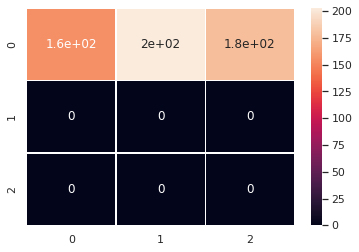

In [45]:
c_mat=tf.math.confusion_matrix(np.argmax(my_predictions, axis=-1),np.argmax(Y_test, axis=-1))
ax = sns.heatmap(c_mat,annot=True,linewidths=.5)